In [5]:
import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import shape
from rasterio.plot import show

# Paths to input data
ortho_path = "D:\downl\SURINOVA_CBE_ORTHO.tif"
dtm_path = "D:\downl\SURINOVA_CBE_DTM.tif"
dsm_path = "D:\downl\SURINOVA_CBE_DSM.tif"

# Load ortho, DTM, and DSM data
with rasterio.open(ortho_path) as src:
    ortho = src.read(1)
    ortho_profile = src.profile
    ortho_transform = src.transform

with rasterio.open(dtm_path) as src:
    dtm = src.read(1)
    dtm_profile = src.profile
    dtm_transform = src.transform

with rasterio.open(dsm_path) as src:
    dsm = src.read(1)



In [ ]:
import rasterio.warp

# Resample DTM to match the resolution of DSM
dtm_resampled = np.empty_like(dsm)
rasterio.warp.reproject(
    source=dtm,
    destination=dtm_resampled,
    src_transform=dtm_transform,
    src_crs=dtm_profile['crs'],
    dst_transform=ortho_transform,
    dst_crs=ortho_profile['crs'],
    resampling=rasterio.enums.Resampling.nearest
)

# Now perform the subtraction
chm = dsm - dtm_resampled

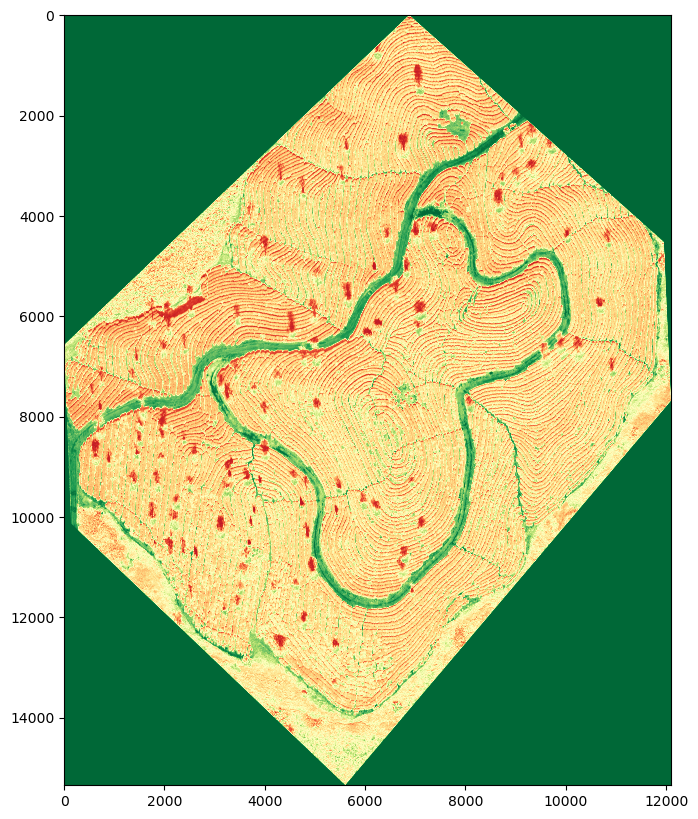

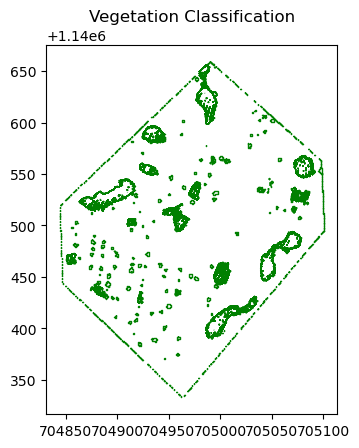

In [18]:
threshold = 2  # Adjust as needed
vegetation = np.where(chm > threshold, 1, 0)

# Convert vegetation raster to vector polygons
shapes = rasterio_shapes(vegetation, transform=ortho_transform)
polygons = [shape(s) for s, _ in shapes if _ == 1]

# Convert polygons to GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=polygons)


fig, ax = plt.subplots(figsize=(10, 10))
show(ortho, cmap='RdYlGn')
gdf.plot(facecolor='none', edgecolor='green')
plt.title("Vegetation Classification")
plt.show()




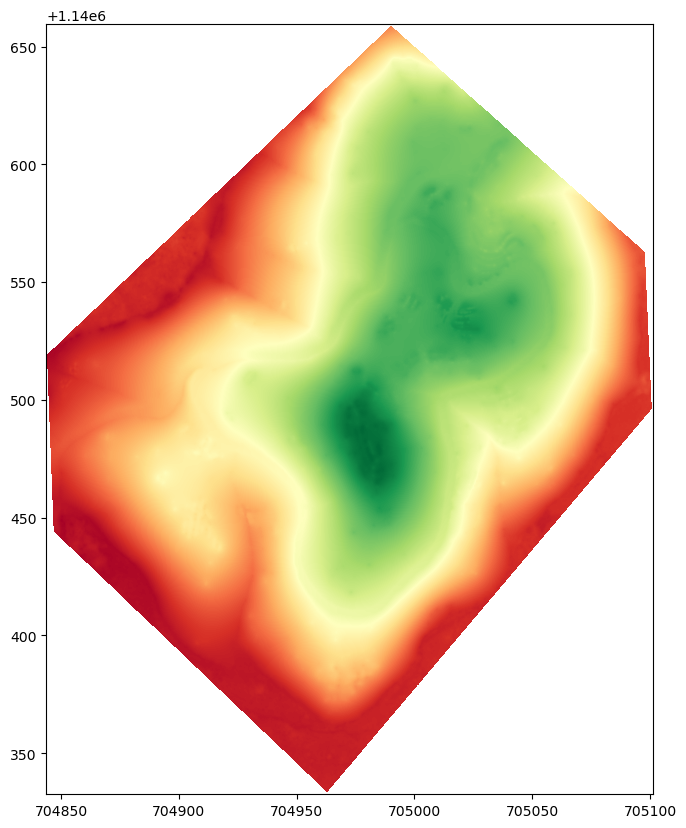

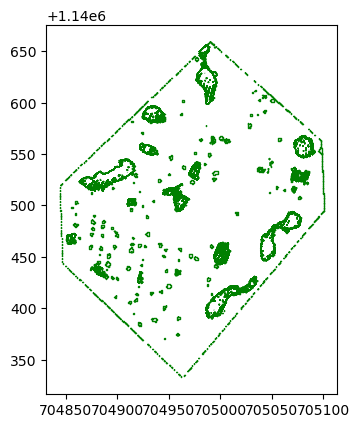

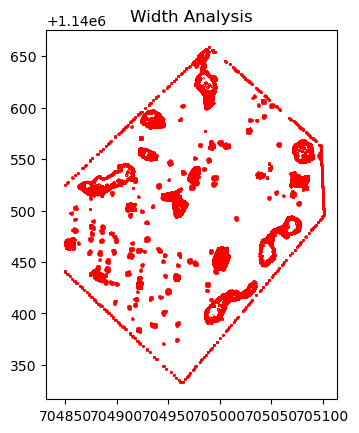

In [34]:
# Width analysis (Assuming rows are aligned with x-axis)
row_widths = [p.bounds[2] - p.bounds[0] for p in polygons]
median_width = np.median(row_widths)
deviation_threshold = 1.2 * median_width

# Identify regions with significant width deviation
deviation_regions = gdf[row_widths > deviation_threshold]

# Plot width analysis results
fig, ax = plt.subplots(figsize=(10, 10))
show(dtm, cmap='RdYlGn')
gdf.plot(facecolor='none', edgecolor='green')
deviation_regions.plot(facecolor='none', edgecolor='red', linewidth=2)
plt.title("Width Analysis")
plt.show()

In [35]:
output_shapefile_path = "vegetation_polygons.shp"
gdf.to_file(output_shapefile_path)

# Save the width analysis results
output_width_analysis_path = "width_analysis_results.shp"
deviation_regions.to_file(output_width_analysis_path)

In [36]:
# Calculate area of each polygon and store it in a new column
gdf['area_sqm'] = gdf.geometry.area

# Print the GeoDataFrame to verify the new column
print(gdf.head())

# Save the GeoDataFrame to a shapefile
output_shapefile_path = "vegetation_polygons.shp"
gdf.to_file(output_shapefile_path)


                                            geometry  area_sqm   width_m
0  POLYGON ((704990.101 1140659.405, 704990.122 1...  0.002722  0.063896
1  POLYGON ((704990.229 1140659.363, 704990.229 1...  0.000907  0.042598
2  POLYGON ((704990.335 1140659.277, 704990.335 1...  0.001361  0.042598
3  POLYGON ((704989.994 1140659.299, 704990.016 1...  0.002722  0.063896
4  POLYGON ((704990.442 1140659.171, 704990.442 1...  0.002268  0.063896


Width Analysis Report:
Total number of plantation rows: 8738
Number of rows with width deviation (> 1.2 meters): 156
Percentage of rows with width deviation: 1.79%


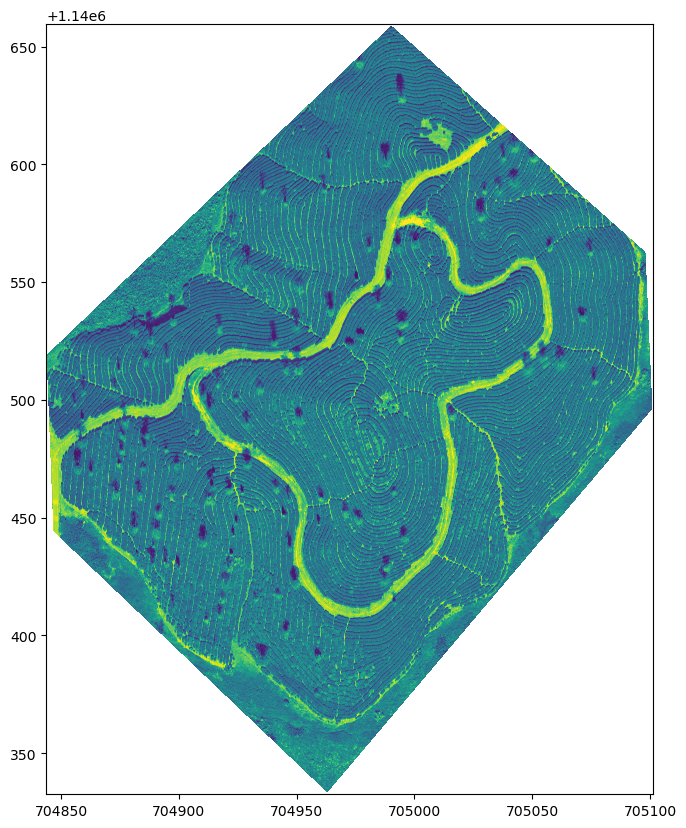

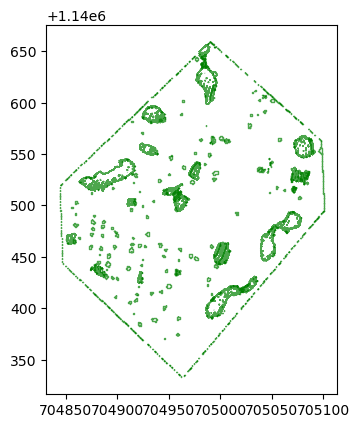

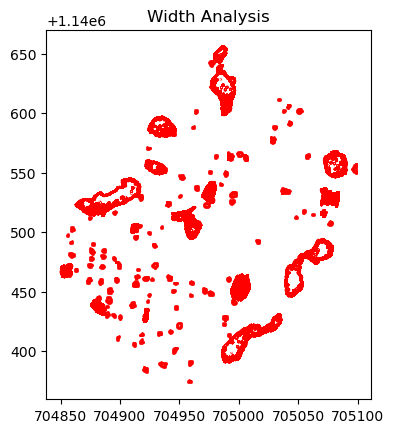

In [37]:
# Calculate the width of each plantation row
gdf['width_m'] = gdf.geometry.apply(lambda geom: geom.bounds[2] - geom.bounds[0])

# Identify regions where the bush width exceeds 1.2 meters
deviation_regions = gdf[gdf['width_m'] > 1.2]

# Generate a width analysis report
total_rows = len(gdf)
deviation_rows = len(deviation_regions)
percent_deviation = (deviation_rows / total_rows) * 100

print("Width Analysis Report:")
print("Total number of plantation rows:", total_rows)
print("Number of rows with width deviation (> 1.2 meters):", deviation_rows)
print("Percentage of rows with width deviation: {:.2f}%".format(percent_deviation))

# Save the deviation regions to a shapefile
output_deviation_path = "D:\downloads\width_deviation_regions.shp"
deviation_regions.to_file(output_deviation_path)

# You can also visualize the deviation regions if needed
# Plot width analysis results
fig, ax = plt.subplots(figsize=(10, 10))
show(ortho)
gdf.plot( facecolor='none', edgecolor='green', alpha=0.7)
deviation_regions.plot(facecolor='none', edgecolor='red', linewidth=2)
plt.title("Width Analysis")
plt.show()


In [38]:
import rasterio

# Define the paths to the DTM, DSM, and ortho files
ortho_path = "D:\downl\SURINOVA_CBE_ORTHO.tif"
dtm_path = "D:\downl\SURINOVA_CBE_DTM.tif"
dsm_path = "D:\downl\SURINOVA_CBE_DSM.tif"

# Open the DTM, DSM, and ortho files to get their bounding boxes
with rasterio.open(dtm_path) as dtm_src, rasterio.open(dsm_path) as dsm_src, rasterio.open(ortho_path) as ortho_src:
    # Get the bounding boxes (extent) of the files
    dtm_bounds = dtm_src.bounds
    dsm_bounds = dsm_src.bounds
    ortho_bounds = ortho_src.bounds

# Define the bounding box that encompasses all three files
combined_bounds = (
    min(dtm_bounds.left, dsm_bounds.left, ortho_bounds.left),
    min(dtm_bounds.bottom, dsm_bounds.bottom, ortho_bounds.bottom),
    max(dtm_bounds.right, dsm_bounds.right, ortho_bounds.right),
    max(dtm_bounds.top, dsm_bounds.top, ortho_bounds.top)
)

# Define the range of latitude and longitude within the combined bounds
min_latitude, max_latitude = combined_bounds[1], combined_bounds[3]
min_longitude, max_longitude = combined_bounds[0], combined_bounds[2]

# Generate random latitude and longitude coordinates within the combined bounds
import random

# Random start point
start_latitude = random.uniform(min_latitude, max_latitude)
start_longitude = random.uniform(min_longitude, max_longitude)

# Random end point
end_latitude = random.uniform(min_latitude, max_latitude)
end_longitude = random.uniform(min_longitude, max_longitude)

# Print the random start and end points
print("Random Start Point (Latitude, Longitude):", start_latitude, ",", start_longitude)
print("Random End Point (Latitude, Longitude):", end_latitude, ",", end_longitude)


Random Start Point (Latitude, Longitude): 1140418.2526683446 , 705059.2565544606
Random End Point (Latitude, Longitude): 1140512.1884523593 , 704870.8895559123


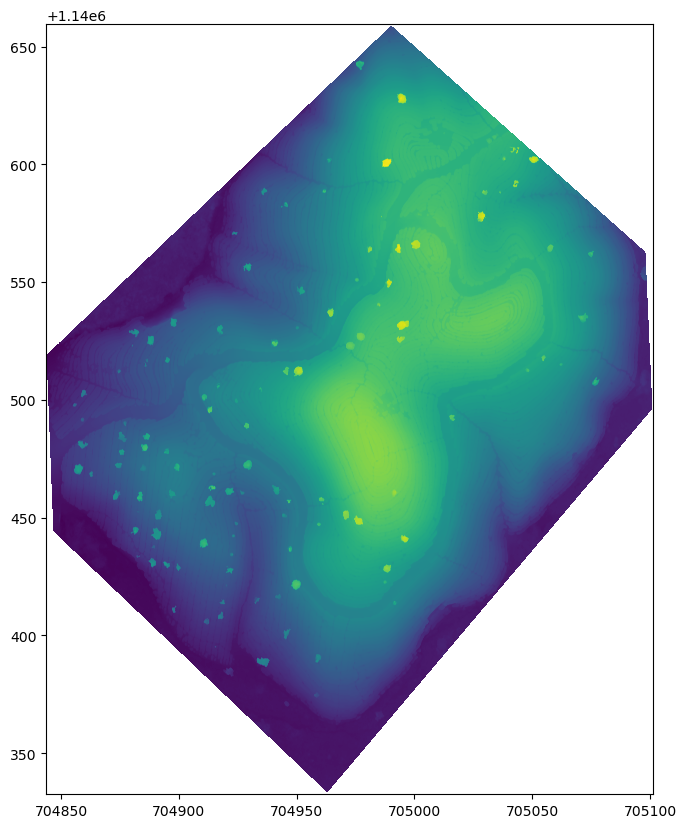

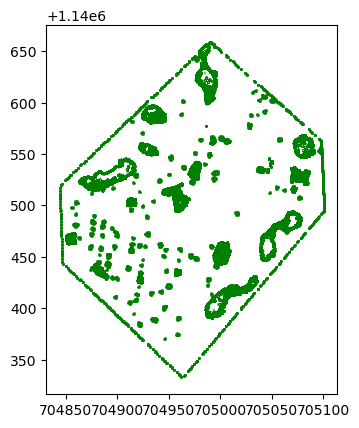

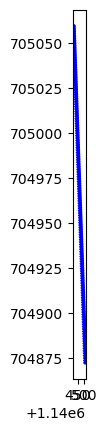

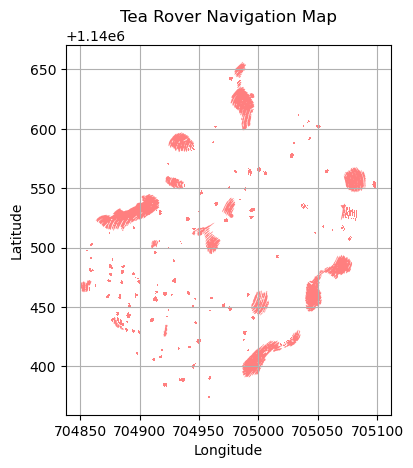

In [42]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString

# Define the start and end points for the tea rover's path (sample points)
start_point = (start_latitude, start_longitude)  # Define the starting point (sample latitude and longitude)
end_point = (end_latitude, end_longitude)  # Define the ending point (sample latitude and longitude)
rover_width = 1.5  # Width of the tea rover in meters

# Create a LineString object representing the path
path_line = LineString([start_point, end_point])

# Generate latitude and longitude coordinates along the path
path_length = path_line.length
num_points = int(path_length / rover_width)  # Adjust based on desired point density
path_points = [path_line.interpolate(i * rover_width) for i in range(num_points)]

# Convert the path points to a GeoDataFrame
path_gdf = gpd.GeoDataFrame(geometry=path_points, crs='EPSG:4326')

# Define the path to the plantation boundary shapefile
plantation_shapefile_path = "vegetation_polygons.shp"

# Read the plantation boundary shapefile into a GeoDataFrame
plantation_gdf = gpd.read_file(plantation_shapefile_path)

# Calculate the widths of the plantation rows
plantation_gdf['row_width'] = plantation_gdf.bounds.maxx - plantation_gdf.bounds.minx

# Identify critical areas where the bush width exceeds 1.2 meters
critical_areas = plantation_gdf[plantation_gdf['row_width'] > 1.2]

# Plot the plantation boundary, tea rover navigation path, and critical areas
fig= plt.subplots(figsize=(10, 10))
show(dsm)
plantation_gdf.plot( facecolor='none', edgecolor='green', linewidth=2)  # Plot plantation boundary
path_gdf.plot(color='blue', linestyle='--', markersize=5)  # Plot tea rover navigation path
critical_areas.plot(facecolor='red', alpha=0.5)  # Highlight critical areas
plt.title("Tea Rover Navigation Map")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


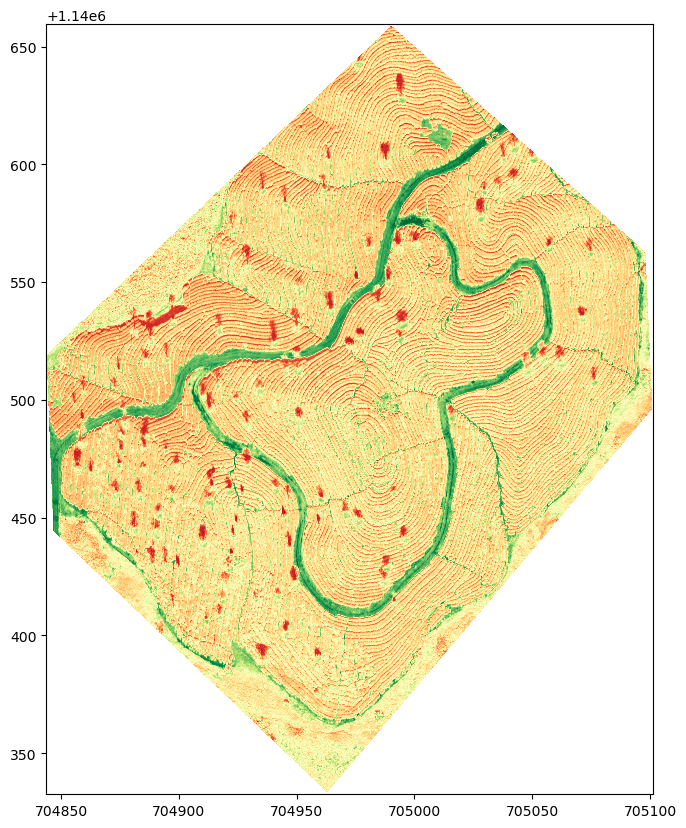

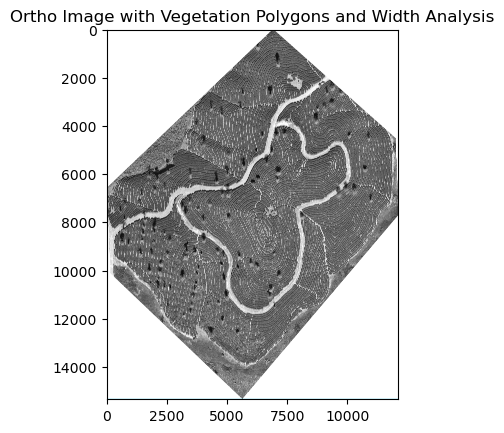

In [46]:
import geopandas as gpd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import cv2

# Load the ortho image
ortho_path = "D:\downl\SURINOVA_CBE_ORTHO.tif"
ortho = rasterio.open(ortho_path)

# Plot the ortho image
plt.figure(figsize=(10, 10))
show(ortho, cmap='RdYlGn')
plt.title("Ortho Image with Vegetation Polygons and Width Analysis")

# Plot vegetation polygons
gdf.plot(ax=plt.gca(), facecolor='none', edgecolor='green')

# Plot deviation regions
deviation_regions.plot(ax=plt.gca(), facecolor='none', edgecolor='red', linewidth=2)

# Convert ortho image to numpy array
ortho_array = ortho.read(1)

# Convert to uint8 for contour detection
ortho_uint8 = (ortho_array * 255 / ortho_array.max()).astype('uint8')

# Find contours
contours, _ = cv2.findContours(ortho_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image
img_copy = cv2.cvtColor(ortho_uint8, cv2.COLOR_GRAY2RGB)
cv2.drawContours(img_copy, contours, -1, (255, 255, 153), thickness=2)

# Draw bounding box around the largest contour
rect = cv2.minAreaRect(contours[0])
box = cv2.boxPoints(rect)
box = box.astype('int')
cv2.polylines(img_copy, [box], True, (0, 210, 255), thickness=10)

plt.imshow(img_copy, cmap='RdYlGn')
plt.show()
